In [ ]:
import os
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import sys
sys.path.append('./model/') 

from utils import set_seed

set_seed(2025)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/ws6tg/anaconda3/envs/EnvR43/lib/R/'

In [2]:
from muon import prot as pt
from utils import pca

# read data
file_folds = ['./datasets/10X_human_tonsil/slice1/','./datasets/10X_human_tonsil/slice2/','./datasets/10X_human_tonsil/slice3/']  #please replace 'file_fold' with the download path
name = ["slice1", "slice2", "slice3"]
rna_adatas = {}
adt_adatas = {}
for file_fold, name in zip(file_folds, name):
    adata_omics1 = sc.read_h5ad(file_fold + 'adata_rna.h5ad')
    adata_omics2 = sc.read_h5ad(file_fold + 'adata_adt.h5ad')

    adata_omics1.var_names_make_unique()
    adata_omics2.var_names_make_unique()

    from model.utils import Cal_Spatial_Net

    Cal_Spatial_Net(adata_omics1, model="KNN", n_neighbors=6)
    Cal_Spatial_Net(adata_omics2, model="KNN", n_neighbors=6)
    
    rna_adatas[name] = adata_omics1.copy()
    adt_adatas[name] = adata_omics2.copy()



adata_RNA=sc.concat(rna_adatas, label="batch",index_unique="_")
adata_ADT=sc.concat(adt_adatas, label="batch",index_unique="_")

from scipy.sparse import block_diag
import scipy
rna_adj  = block_diag([i.uns["adj"] for i in rna_adatas.values()])
adt_adj  = block_diag([i.uns["adj"] for i in adt_adatas.values()])

adata_RNA.uns['edgeList'] = np.array(np.nonzero(rna_adj))
adata_ADT.uns['edgeList'] = np.array(np.nonzero(adt_adj))

The graph contains 25956 edges, 4326 cells.
6.0000 neighbors per cell on average.
The graph contains 25956 edges, 4326 cells.
6.0000 neighbors per cell on average.
The graph contains 27114 edges, 4519 cells.
6.0000 neighbors per cell on average.
The graph contains 27114 edges, 4519 cells.
6.0000 neighbors per cell on average.
The graph contains 27126 edges, 4521 cells.
6.0000 neighbors per cell on average.
The graph contains 27126 edges, 4521 cells.
6.0000 neighbors per cell on average.


In [3]:
adata_RNA.obs['anno']=adata_RNA.obs['final_annot'].map({"tonsillar parenchyma":"tonsillar parenchyma"  ,    
"lymphoid follicle" :"lymphoid follicle"  ,             
"connective & epithelial tissue" :"connective & epithelial tissue"  ,
"connective and epithelial tissue" :"connective & epithelial tissue" ,   
"germinal center":"germinal center" ,                      
"germinal Center":"germinal center" })

In [4]:
from utils import harmony
# RNA
sc.pp.filter_genes(adata_RNA, min_cells=10)
sc.pp.highly_variable_genes(adata_RNA, flavor="seurat_v3", n_top_genes=5000)
sc.pp.normalize_total(adata_RNA, target_sum=1e4)
sc.pp.log1p(adata_RNA)


adata_RNA.raw=adata_RNA
adata_RNA = adata_RNA[:, adata_RNA.var['highly_variable']]
adata_RNA.obsm['X_pca'] = pca(adata_RNA, n_comps=50)
harmony(adata_RNA,'X_pca',"batch")

# Protein
pt.pp.clr(adata_ADT)
adata_ADT.obsm['X_pca'] = pca(adata_ADT, n_comps=30)
harmony(adata_ADT,'X_pca',"batch")

/tmp/ipykernel_4037623/4247252701.py:11: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata_RNA.obsm['X_pca'] = pca(adata_RNA, n_comps=50)


Use GPU mode.
	Initialization is completed.
	Completed 1 / 20 iteration(s).
	Completed 2 / 20 iteration(s).
	Completed 3 / 20 iteration(s).
	Completed 4 / 20 iteration(s).
	Completed 5 / 20 iteration(s).
Reach convergence after 5 iteration(s).
Use GPU mode.


/home/ws6tg/anaconda3/envs/scvi/lib/python3.9/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


	Initialization is completed.
	Completed 1 / 20 iteration(s).
	Completed 2 / 20 iteration(s).
	Completed 3 / 20 iteration(s).
	Completed 4 / 20 iteration(s).
	Completed 5 / 20 iteration(s).
	Completed 6 / 20 iteration(s).
	Completed 7 / 20 iteration(s).
	Completed 8 / 20 iteration(s).
	Completed 9 / 20 iteration(s).
	Completed 10 / 20 iteration(s).
	Completed 11 / 20 iteration(s).
	Completed 12 / 20 iteration(s).
	Completed 13 / 20 iteration(s).
	Completed 14 / 20 iteration(s).
	Completed 15 / 20 iteration(s).
Reach convergence after 15 iteration(s).


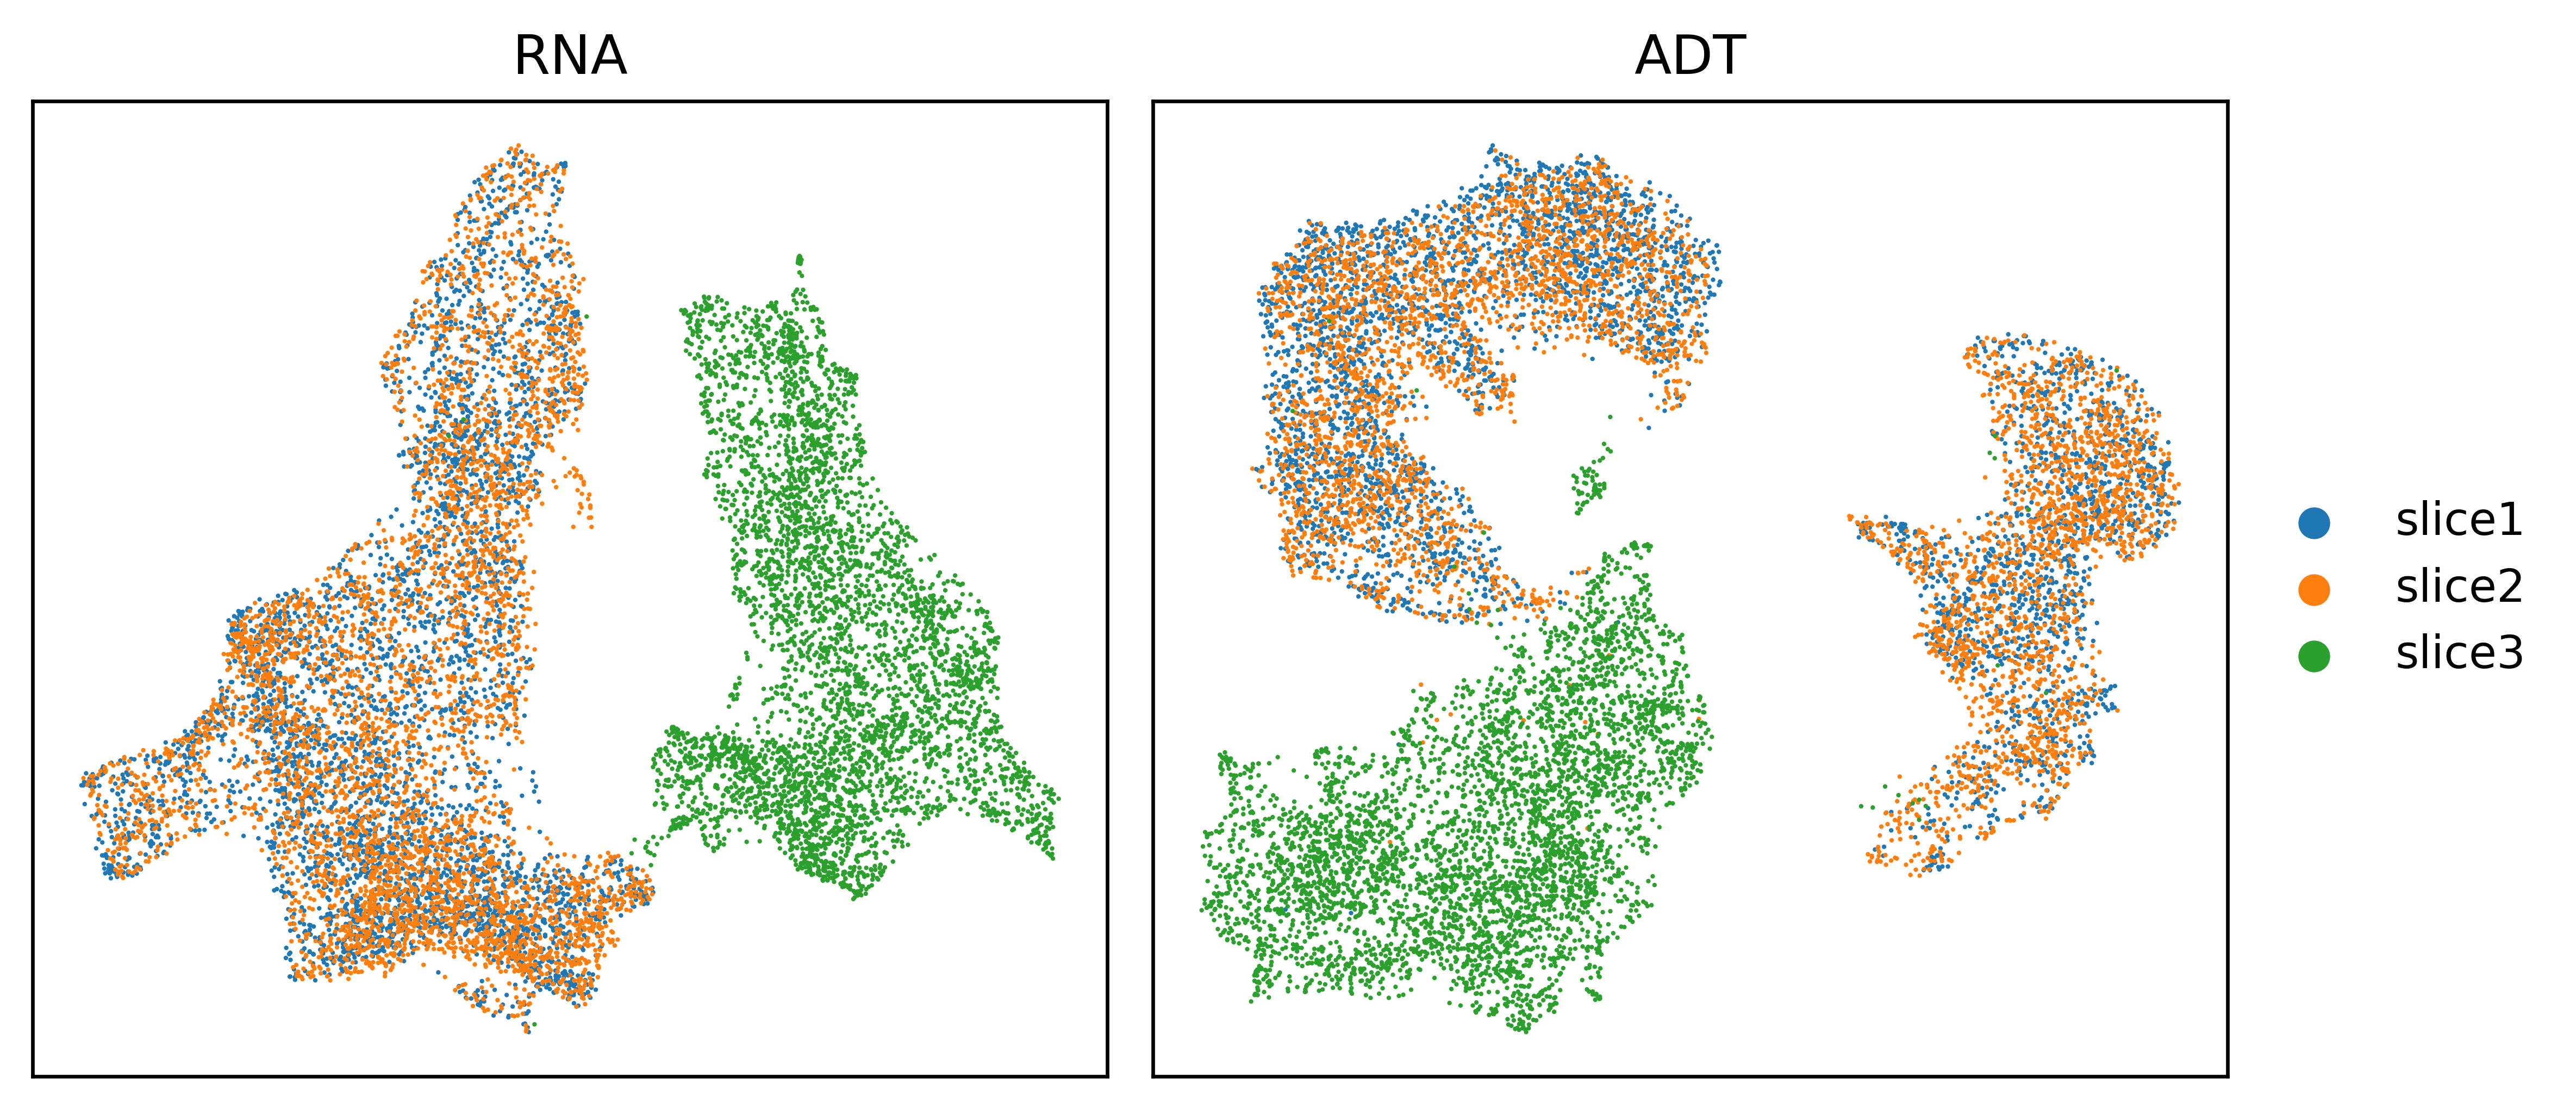

In [5]:
from matplotlib import pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(8, 3.5),dpi=600)
sc.pp.neighbors(adata_RNA, use_rep='X_pca', n_neighbors=10)
sc.tl.umap(adata_RNA)
sc.pl.umap(adata_RNA, color='batch', ax=ax_list[0], title='RNA', s=4 ,show=False)
ax_list[0].get_legend().remove()
sc.pp.neighbors(adata_ADT, use_rep='X_pca', n_neighbors=10)
sc.tl.umap(adata_ADT)
sc.pl.umap(adata_ADT, color='batch', ax=ax_list[1], title='ADT', s=4, show=False)
ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].set_xlabel("")
ax_list[0].set_ylabel("")
plt.tight_layout(w_pad=1)
plt.show()

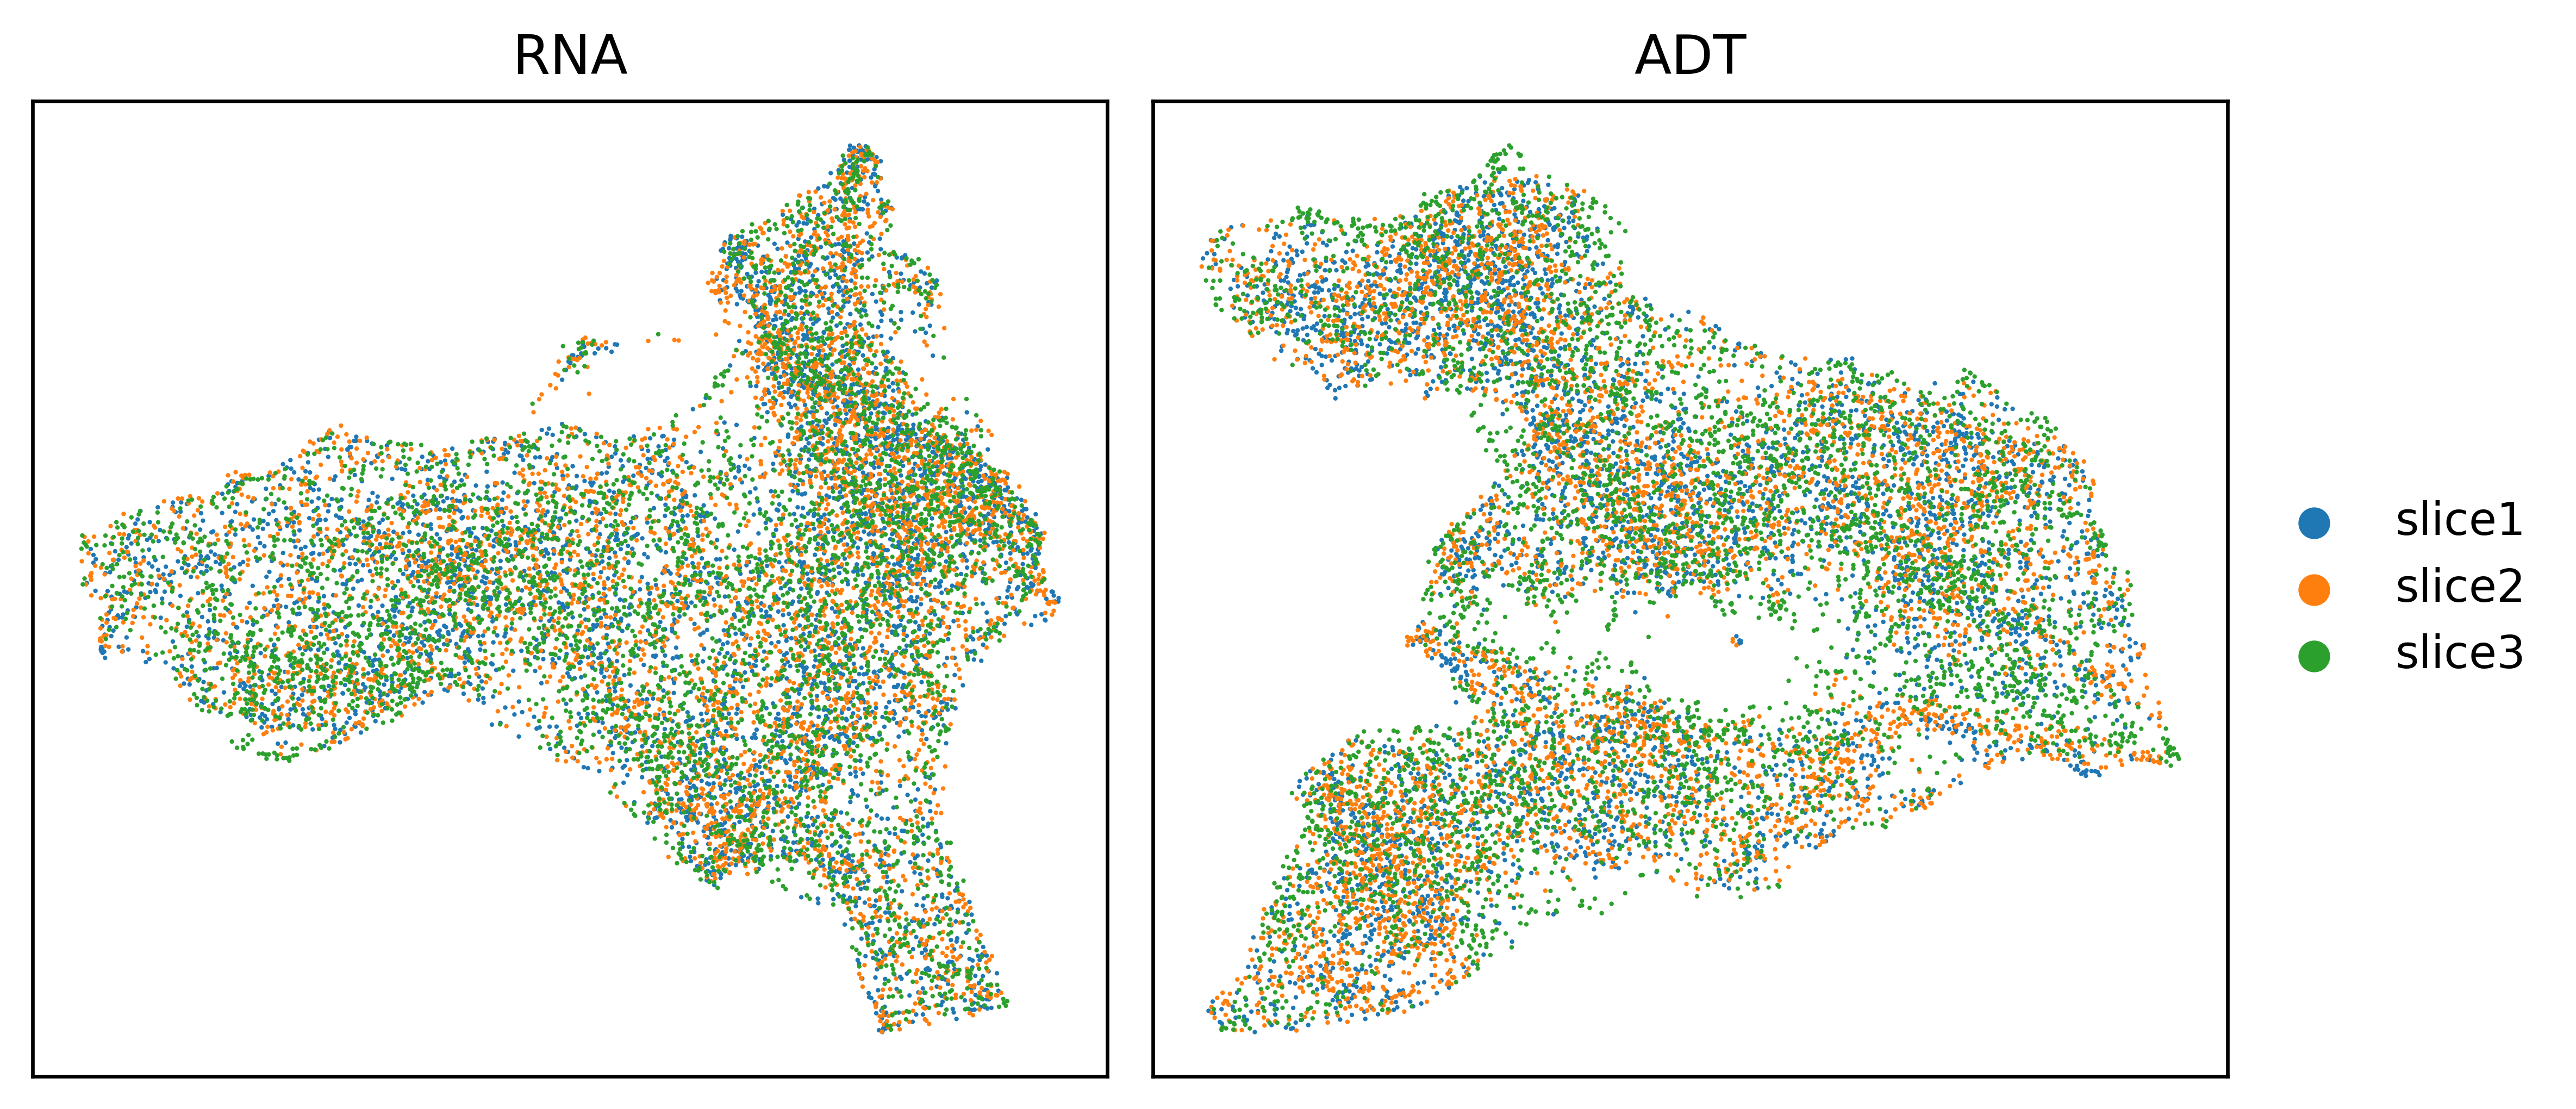

In [6]:
from matplotlib import pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(8, 3.5),dpi=600)
sc.pp.neighbors(adata_RNA, use_rep='X_pca_harmony', n_neighbors=10)
sc.tl.umap(adata_RNA)
sc.pl.umap(adata_RNA, color='batch', ax=ax_list[0], title='RNA', s=4 ,show=False)
ax_list[0].get_legend().remove()
sc.pp.neighbors(adata_ADT, use_rep='X_pca_harmony', n_neighbors=10)
sc.tl.umap(adata_ADT)
sc.pl.umap(adata_ADT, color='batch', ax=ax_list[1], title='ADT', s=4, show=False)
ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].set_xlabel("")
ax_list[0].set_ylabel("")
plt.tight_layout(w_pad=1)
plt.show()

In [7]:
from utils import MMN_batch

adata_list=[adata_RNA,adata_ADT]
x = [torch.FloatTensor(adata.obsm["X_pca_harmony"]).to(device) for adata in adata_list]
triplet_samples_list = [MMN_batch(adata.obsm["X_pca_harmony"],adata.obs["batch"],far_frac=0.8,top_k=1) for adata in adata_list]

Batch slice1 vs slice2: 1128 MNN (top-1) triplets
Batch slice1 vs slice3: 1061 MNN (top-1) triplets
Batch slice2 vs slice3: 1081 MNN (top-1) triplets
Batch slice1 vs slice2: 1232 MNN (top-1) triplets
Batch slice1 vs slice3: 1049 MNN (top-1) triplets
Batch slice2 vs slice3: 995 MNN (top-1) triplets


In [8]:
from train import train_SMART

edges =[torch.LongTensor(adata.uns["edgeList"]).to(device) for adata in adata_list ]

model=train_SMART(features=x,
    edges=edges,
    triplet_samples_list=triplet_samples_list,
    weights=[1,1,1,1],
    emb_dim=32, 
    n_epochs=150,
    lr=0.005,
    weight_decay=1e-6,
    device = device,
    window_size=10,
    slope=0.0001
    )

adata_RNA.obsm["SMART"]=model(x, edges)[0].cpu().detach().numpy()

from model.utils import clustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score, \
    homogeneity_score, mutual_info_score, v_measure_score

tool = 'mclust'  # mclust, leiden, and louvain


clustering(adata_RNA, key='SMART', add_key='SMART', n_clusters=6, method=tool, use_pca=True)
adata_RNA1=adata_RNA[~adata_RNA.obs['anno'].isna()]
ari = adjusted_rand_score(adata_RNA1.obs['anno'], adata_RNA1.obs["SMART"])
print(ari)

 93%|█████████████████████████████████████████████████████████████████████████▏     | 139/150 [00:03<00:00, 42.02it/s]


Stopping for flat trend


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
0.1738464070342603


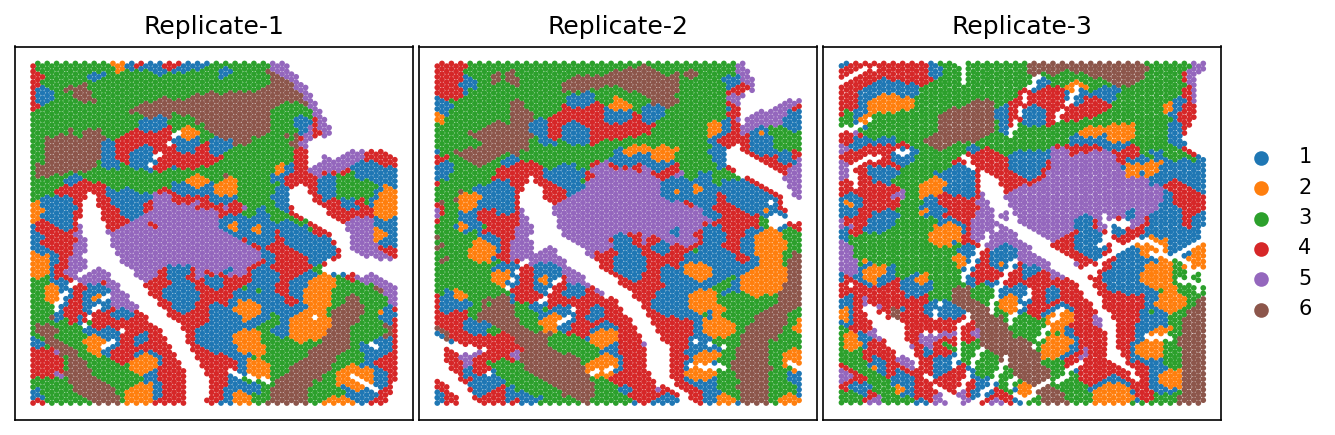

In [10]:
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 3, figsize=(9, 3),dpi=150)
sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]=="slice1"].copy(), basis='spatial', color='SMART', ax=ax_list[0], title='Replicate-1', s=30, show=False)
sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]=="slice2"].copy(), basis='spatial', color='SMART', ax=ax_list[1], title='Replicate-2', s=30, show=False)
sc.pl.embedding(adata_RNA[adata_RNA.obs["batch"]=="slice3"].copy(), basis='spatial', color='SMART', ax=ax_list[2], title='Replicate-3', s=30, show=False)

ax_list[1].set_xlabel("")
ax_list[1].set_ylabel("")
ax_list[0].set_xlabel("")
ax_list[0].set_ylabel("")
ax_list[2].set_xlabel("")
ax_list[2].set_ylabel("")

ax_list[0].get_legend().remove()
ax_list[1].get_legend().remove()
plt.tight_layout(w_pad=0.3)
plt.show()